<div style="text-align:left;">

# <span style="text-decoration: underline;"><b>Projet de fin de formation - DATAGONG</b></span>

</div>


## <b>Analyse e‑commerce 2023 vs 2024 — thelook_ecommerce </b>

### Contexte & périmètre
Analyse de la performance e-commerce TheLook Europe sur le périmètre :
- Périmètre : France · Women · 01/01/2023–31/12/2024.
- Objectif : comparer 2023 vs 2024 via une EDA et des KPI métier (CA, marge, panier, retours, ré-achat).
- Approche : exploration descriptive (temps, produits, géographie) puis formalisation des indicateurs.


### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données
Commençons par importer notre jeu de données sous format csv et le convertir en DataFrame.

In [1]:
import pandas as pd
import numpy as np
# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

# Dimensions du jeu de données
print(f'Le jeu de données fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

# En-tête du jeu de données
df.head()

Le jeu de données fait 1679 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,19425,28112,6983,2023-01-01 06:18:03+00:00,Shipped,29.500000,16.048000,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
1,19425,28113,10597,2023-01-01 06:44:58+00:00,Shipped,20.000000,10.000000,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris


On observe d'après le notebook `test_checks_cohérence` que l'essentiel des valeurs manquantes se trouve dans les deux variables `shipped_at` et `delivered_at`. Celles-ci reflètent l’absence d’information logistique disponible pour certaines lignes (statuts non finalisés, annulation, ou données non renseignées).
Il existe également 2 valeurs manquantes pour la colonne brand.

On peut d'ores et déjà changer le type object en date pour les colonnes de date et en category pour les colonnes catégorielles . 

In [2]:
# Colonnes de date 
col_dates = [
    "item_created_at", 
    "order_created_at", 
    "shipped_at", 
    "delivered_at"
]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Maintenant que les dates sont parsées, nous allons déterminer pour quelles colonnes il faudrait typer en category.

In [3]:
# Nombre de modalités pour les colonnes object
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


 Les colonnes `brand` et `product_name` ont un nombre important de modalités uniques. Ainsi, nous les laisserons en format object.

 Changeons le type des autres colonnes catégorielles :

In [4]:
# Colonnes catégorielles
cat_list = [
    "item_status", 
    "category", 
    "department", 
    "order_status", 
    "gender", 
    "country", 
    "state", 
    "city"
]

# Changement des type object en category pour les variables catégorielles
df[cat_list] = df[cat_list].astype('category')

Les colonnes de dates ont été parsées au format datetime. Les variables à faible cardinalité ont été typées en catégorie (item_status, category, order_status, state…), tandis que `brand` et `product_name` ont été conservées en object en raison de leur cardinalité élevée.
. On crée maintenant notre dictionnaire de données permettant de décrire les colonnes.

#### 1.2. Création du mini-dictionnaire de données
On va maintenant procéder à la création du du mini-dictionnaire des données.

**Grain du dataset**  
Chaque ligne du fichier correspond à **un article (ligne de commande)** associé :
- à une **commande** (`order_id`),
- à un **client** (`user_id`),
- à un **produit** (`product_id`).

Le fichier CSV est **fourni par l’équipe pédagogique** et correspond au sous-périmètre :
France × Women × 2023–2024.  
Il constitue la base unique de l’analyse exploratoire (EDA) en Python.

---

| Colonne | Type | Définition métier | Remarques |
|------|------|--------------------|-----------|
| `order_id` | int64 | Identifiant unique de la commande. | Une commande peut contenir plusieurs articles. |
| `order_item_id` | int64 | Identifiant unique de la ligne de commande (article). | Doit être unique. Sert à vérifier l’absence de doublons métier. |
| `product_id` | int64 | Identifiant unique du produit acheté. | – |
| `item_created_at` | datetime (UTC) | Date de création de la ligne de commande. | Date de référence pour le périmètre temporel. |
| `item_status` | category | Statut de la ligne de commande (ex. `Complete`, `Returned`). | – |
| `sale_price` | float64 | Prix de vente de l’article. | – |
| `cost` | float64 | Coût d’achat ou de fabrication du produit. | – |
| `category` | category | Catégorie du produit. | – |
| `department` | category | Département du produit (Women). | Variable constante dans le périmètre. |
| `brand` | object | Marque du produit. | – |
| `product_name` | object | Nom du produit. | – |
| `order_status` | category | Statut de la commande (ex. `Complete`, `Shipped`). | Statut global, distinct du statut des lignes. |
| `order_created_at` | datetime (UTC) | Date de création de la commande. | Utilisée pour les analyses au niveau commande. |
| `shipped_at` | datetime (UTC) | Date d’expédition de l’article. | Valeurs manquantes attendues. |
| `delivered_at` | datetime (UTC) | Date de livraison de l’article. | Valeurs manquantes attendues. |
| `user_id` | int64 | Identifiant unique du client. | Un client peut passer plusieurs commandes. |
| `gender` | category | Genre déclaré du client. | – |
| `country` | category | Pays de résidence du client. | Variable constante dans le périmètre. |
| `state` | category | Région / État du client. | – |
| `city` | category | Ville du client. | – |

---

**Notes méthodologiques**
- Le dataset est au **grain ligne de commande** (article), et non au niveau commande.
- Les colonnes logistiques (`shipped_at`, `delivered_at`) peuvent légitimement contenir des valeurs manquantes.


### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons
On va chercher dans un premier temps à voir s'il existe des observations intégralement dupliquées.

In [5]:
# Recherche d'observations intégralement dupliquées 
print(f"Il y a {df.duplicated().sum()} ligne(s) intégralement dupliquée(s)")

Il y a 0 ligne(s) intégralement dupliquée(s)


`order_item_id` étant la clé Métier, il est primordial de vérifier son unicité :

In [6]:
df['order_item_id'].is_unique
df['order_item_id'].duplicated().sum()

np.int64(0)

Nous constatons qu'il n'y a aucune ligne intégralement dupliquée et qu'aucun doublon n’est détecté sur order_item_id, ce qui confirme l’unicité des lignes de vente et la fiabilité des agrégations futures.

#### 2.2. Traitement des valeurs manquantes
On va maintenant chercher à savoir s'il existe des valeurs manquantes et comment les traiter. On a vu que pour certains champs comme `shipped_at` et `delivered_at` il était normal d'avoir des valeurs manquantes. Celles-ci n’affectent pas les analyses de performance (CA, marge, retours) car elles ne sont pas utilisées dans les calculs ultérieurs. 
Il sera préférable de les laisser simplement en NaT. 


Deux valeurs manquantes sont présentes sur brand (0,12 %). Les product_id étant uniques dans l’extrait, l’imputation par correspondance est impossible ; la modalité missing est donc appliquée. (cf notebook `test_checks_cohérence`)

In [7]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

Les valeurs manquantes concernent principalement les dates de livraison et d’expédition, ce qui est cohérent avec des commandes non encore livrées ou annulées.
La variable `brand` comporte 2 valeurs manquantes sur 1 679 lignes
(soit 0,12 % du jeu de données). Ces valeurs ont été imputées
sous la modalité `"missing"` faute de plus d'informations. Cette proportion est jugée négligeable
et n’impacte pas les analyses exploratoires.


#### 2.3. Cohérence des bornes temporelles


Nous devons maintenant nous assurer que les bornes temporelles respectent bien le périmètre indiqué (2023-2024). Le périmètre temporel est appliqué au grain ligne via `item_created_at`, plus robuste que `order_created_at` aux effets de frontière (commande créée à J-1, lignes enregistrées à J).

In [8]:
# Création des colonnes year et month
df["year"] = df["item_created_at"].dt.year
df["month"] = df["item_created_at"].dt.month

D'après les résultats du notebook annexe, toutes les dates de création de lignes sont comprises entre 2023 et 2024, 
le périmètre temporel est respecté.


Pour terminer, nous contrôlons la cohérence chronologique des différentes
étapes du cycle de vie des commandes (création, expédition et livraison).
L’objectif est de détecter d’éventuelles incohérences temporelles et
d’évaluer leur impact sur les analyses exploratoires.


In [9]:
# Controle de la cohérence chronologique order_created_at < shipped_at
df[
    (df["shipped_at"].notna()) &
    (df["shipped_at"] < df["order_created_at"])
].shape[0]

0

In [10]:
# Contrôle de la cohérence chronologique shipped_at < delivered_at
mask_delivered = (
    df["delivered_at"].notna()
    & df["shipped_at"].notna()
    & (df["delivered_at"] < df["shipped_at"])
)

mask_delivered.sum()

np.int64(0)

Les contrôles de cohérence temporelle effectués sur les dates
d’expédition et de livraison ne révèlent aucune incohérence
chronologique sur les lignes concernées.

**Conclusion des contrôles de qualité**

Les contrôles effectués n’ont pas mis en évidence d’anomalies bloquantes.
Les valeurs manquantes observées concernent essentiellement des variables logistiques non utilisées dans les calculs de performance.
Les identifiants de lignes (`order_item_id`) sont uniques, garantissant la fiabilité des agrégations.
Les données sont jugées exploitables pour les analyses exploratoires et le calcul des KPI. La suite de l’analyse se concentre sur une exploration descriptive visant à caractériser la structure du chiffre d’affaires réalisé (ventes finalisées) selon le temps, les produits et la géographie.


### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût
Les analyses de distribution portent sur l’ensemble des statuts afin de caractériser la structure des données. Par la suite, les analyses de contribution se concentreront sur les ventes finalisées ("Complete").

Commençons tout d'abord par faire un contrôle qualité Métier rapide sur les prix de vente et les coûts. Ceux-ci ne doivent en aucun cas être négatifs, de plus le prix de vente doit toujours être supérieur au coût qui lui est associé.

Après contrôles (voir annexe), aucune valeur aberrante n’est observée sur les variables de prix et de coût.
Les prix de vente sont strictement positifs et supérieurs aux coûts associés,
ce qui sécurise les analyses ultérieures de performance.


Poursuivons avec la distribution des données liées aux prix de vente et au coût des produits. Utilisons pour cela la méthode describe().

In [11]:
# Méthode describe sur les colonnes prix de vente et coût
df[["sale_price", "cost"]].describe()

,sale_price,cost
count,1679.000000,1679.000000
mean,57.021769,27.460066
std,69.682245,31.854450
min,1.820000,0.749840
25%,19.990000,9.681000
50%,38.000000,18.230800
75%,68.000000,33.232345
max,903.000000,437.052001


Les ordres de grandeur sont cohérents ; une asymétrie à droite est observée.

Nous pouvons également représenter nos données avec un histogramme et ainsi avoir une meilleure idée de la structure des prix de vente/coûts.

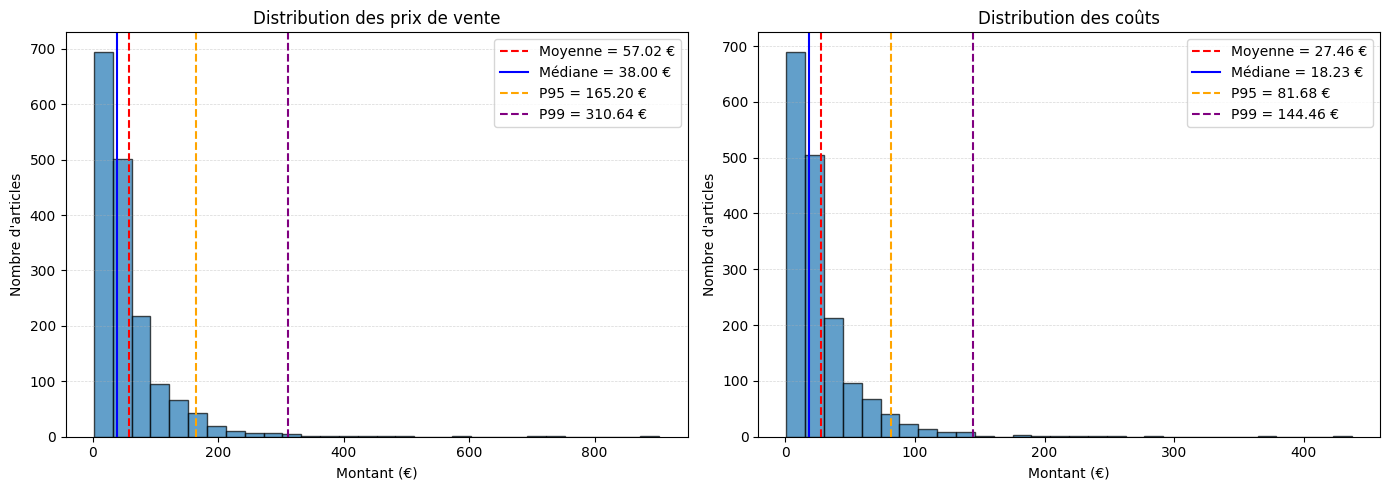

In [12]:
import matplotlib.pyplot as plt

# Titres
titles = {
    "sale_price": "Distribution des prix de vente",
    "cost": "Distribution des coûts"
}

# Colonnes
colonnes = ["sale_price", "cost"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, colonnes):
    # Sélection de la série
    x = df[col].dropna()

    # Statistiques de référence
    mean = x.mean()
    median = x.median()
    p95 = x.quantile(0.95)
    p99 = x.quantile(0.99)

    # Histogramme
    ax.hist(
        x,
        bins=30,
        edgecolor="black",
        alpha=0.7
    )

    # Lignes statistiques
    ax.axvline(mean, linestyle="--", color="red", label=f"Moyenne = {mean:.2f} €")
    ax.axvline(median, linestyle="-", color="blue", label=f"Médiane = {median:.2f} €")
    ax.axvline(p95, linestyle="--", color="orange", label=f"P95 = {p95:.2f} €")
    ax.axvline(p99, linestyle="--", color="purple", label=f"P99 = {p99:.2f} €")

    # Grille
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Titres et labels
    ax.set_title(titles[col])
    ax.set_xlabel("Montant (€)")
    ax.set_ylabel("Nombre d'articles")
    ax.legend()

plt.tight_layout()
plt.show()


Les distributions des prix de vente et des coûts présentent une forte asymétrie à droite.  
La majorité des articles se situe sur des niveaux de prix relativement faibles, tandis qu’un nombre limité d’articles affiche des valeurs très élevées, générant une longue traîne. Cette asymétrie se reflète dans l’écart marqué entre la moyenne et la médiane, la moyenne étant tirée vers le haut par les valeurs extrêmes.

**Interprétation métier**

Ces distributions suggèrent un catalogue composé majoritairement de produits à prix accessibles, complété par une offre plus restreinte de produits premium. Les articles à prix élevé, bien que peu nombreux, peuvent jouer un rôle disproportionné dans le chiffre d’affaires et la marge.


#### 3.2. Répartition des statuts de lignes de commande et sécurisation du CA réalisé

Afin de compléter cette première exploration globale, il est utile d’examiner la répartition des lignes selon leur statut, afin de mieux comprendre la structure opérationnelle du dataset.

Elle constitue également un point de vigilance méthodologique, dans la mesure où le chiffre d’affaires réalisé est calculé exclusivement à partir des lignes au statut "Complete". 

En effet, la convention projet est de prendre en compte les ventes réalisées correspondent aux lignes item_status = "Complete". Les statuts "Processing", "Shipped" et "Cancelled" sont exclus (revenu non finalisé). Les retours sont analysés séparément (taux de retour). Le “CA réalisé” = somme des sale_price des lignes "Complete".

Les analyses suivantes (faites en annexe `test_checks_cohérence`), visent donc à vérifier que cette convention ne génère pas de biais dans la comparaison inter-annuelle 2023–2024.

**Répartition globale des statuts (toutes années confondues)**

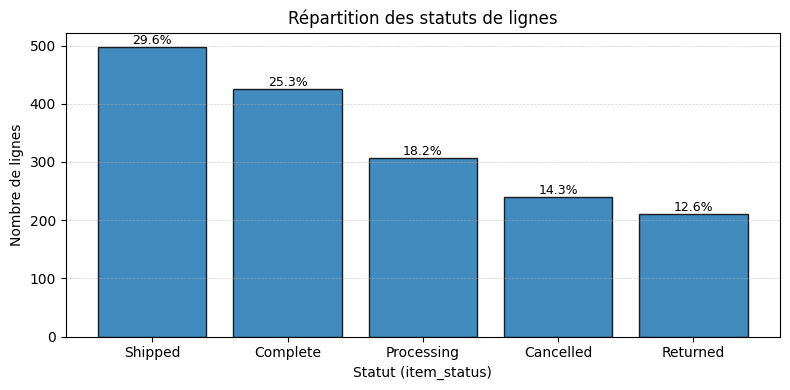

In [13]:
# Comptage des lignes par statut
counts = df["item_status"].value_counts()

# Calcul des parts relatives
pct = (counts / counts.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(counts.index.astype(str), counts.values, edgecolor="black", alpha=0.85)

# Ajout des annotations (%)
for i, (c, p) in enumerate(zip(counts.values, pct.values)):
    ax.text(i, c, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

# Mise en forme et affichage
ax.set_title("Répartition des statuts de lignes")
ax.set_xlabel("Statut (item_status)")
ax.set_ylabel("Nombre de lignes")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

La répartition globale met en évidence la diversité des statuts de lignes et justifie la réalisation de contrôles complémentaires sur la part de lignes Complete par année et par mois, ainsi que sur la cohérence entre statuts commande et article, afin de sécuriser la comparaison inter-annuelle du chiffre d’affaires réalisé.

**Conclusion des contrôles** (voir annexe) : L’ensemble des contrôles réalisés sur les statuts de lignes et de commandes confirme la robustesse de la convention retenue pour le calcul du chiffre d’affaires réalisé (lignes item_status = "Complete"). La progression de la part de ventes finalisées entre 2023 et 2024 ne présente ni biais temporel en fin de période, ni incohérence entre les statuts au niveau ligne et au niveau commande. La hausse du chiffre d’affaires observée en 2024 ne peut donc pas être attribuée à un artefact méthodologique lié aux statuts, mais reflète une amélioration réelle de la finalisation des ventes sur le périmètre étudié.

#### 3.3. Contribution par marque, catégorie, ville, saisonnalité mensuelle 
Maintenant nous allons nous intéresser à la contribution au CA effectivement réalisé sur 2023-2024 des marques, catégories, zones géographiques et selon le mois de l'année. Dans ce projet, le chiffre d’affaires réalisé est défini comme la somme des sale_price des lignes au statut "Complete" (voir convention du projet).
Les graphiques suivants présentent la contribution des principales marques,
catégories et villes au chiffre d’affaires total du périmètre.


##### 3.3.1. Contribution par marque

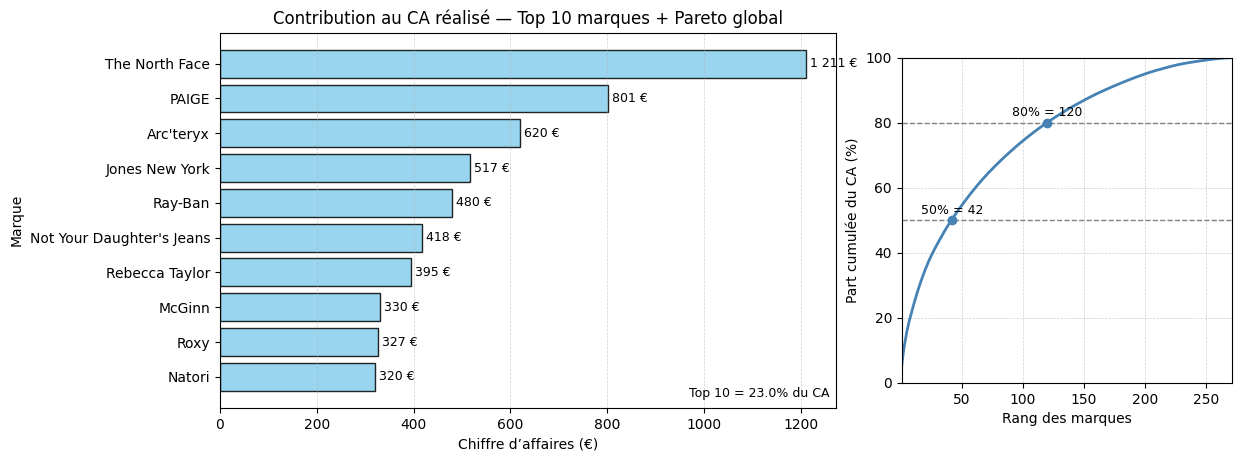

In [64]:
# Paramètre
N = 10

# Filtre ventes réalisées 
df_real = df[df["item_status"] == "Complete"].copy()

# CA par marque (global)
ca_brand = (
    df_real.groupby("brand")["sale_price"]
    .sum()
    .sort_values(ascending=False)
)
total_ca = ca_brand.sum()

# Top N pour affichage (noms visibles) 
top = ca_brand.head(N).sort_values(ascending=True)

# Part du Top N dans le total 
top_share = (top.sum() / total_ca * 100)

# Pareto global (toutes marques)
cum_share = (ca_brand.cumsum() / total_ca) * 100
ranks = np.arange(1, len(cum_share) + 1)

rank_50 = int(np.argmax(cum_share.values >= 50) + 1)
rank_80 = int(np.argmax(cum_share.values >= 80) + 1)

# Figure 
fig = plt.figure(figsize=(11, 5))

# Axe 1 : Top N 
ax = fig.add_axes([0.06, 0.15, 0.56, 0.75])

ax.barh(
    top.index.astype(str),
    top.values,
    color="skyblue",
    edgecolor="black",
    alpha=0.85
)
ax.set_title(f"Contribution au CA réalisé — Top {N} marques + Pareto global")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Marque")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

# Annotations € 
for i, v in enumerate(top.values):
    ax.text(v, i, f" {v:,.0f} €".replace(",", " "), va="center", fontsize=9)

# Petite annotation : part du Top N dans le total 
ax.text(
    0.99, 0.02,
    f"Top {N} = {top_share:.1f}% du CA",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=9
)    

# Axe 2 : Mini Pareto 
axp = fig.add_axes([0.68, 0.20, 0.30, 0.65])

axp.plot(ranks, cum_share.values, color="steelblue", linewidth=2)
axp.set_ylim(0, 100)
axp.set_xlim(1, len(ranks))
axp.set_xlabel("Rang des marques")
axp.set_ylabel("Part cumulée du CA (%)")
axp.grid(True, axis="both", linestyle="--", linewidth=0.5, alpha=0.6)

# Seuils 50/80
axp.axhline(50, color="gray", linestyle="--", linewidth=1)
axp.axhline(80, color="gray", linestyle="--", linewidth=1)
axp.scatter([rank_50, rank_80], [50, 80], color="steelblue", zorder=3)

axp.text(rank_50, 52, f"50% = {rank_50}", ha="center", fontsize=9)
axp.text(rank_80, 82, f"80% = {rank_80}", ha="center", fontsize=9)

plt.show()


**Résultat analytique**
Les marques leaders sont clairement identifiables, avec The North Face en tête, suivie par PAIGE et Arc’teryx. La concentration du chiffre d’affaires reste toutefois faible : 42 marques sont nécessaires pour atteindre 50 % du CA réalisé et 120 marques pour en représenter 80 %, ce qui traduit une logique marquée de longue traîne.

**Implications opérationnelles**
La performance ne repose pas sur 2–3 marques “stars”, mais sur un portefeuille large. Les leviers prioritaires portent donc sur la disponibilité produit, la découvrabilité (search, filtres, recommandations) et la rotation de stock sur l’ensemble du catalogue.
Côté merchandising, maintenir un “Top marques” pour soutenir l’acquisition/conversion (pages marque, placements), tout en optimisant la longue traîne via bundles, cross-sell et mises en avant contextuelles (catégorie / saison).

**Point de vigilance**
La faible dépendance à une marque est un facteur de résilience, mais elle implique un pilotage fin du mix marques pour éviter la sur-dispersion des stocks et un sur-assortiment défavorable à la rotation.

##### 3.3.2. Contribution par catégorie

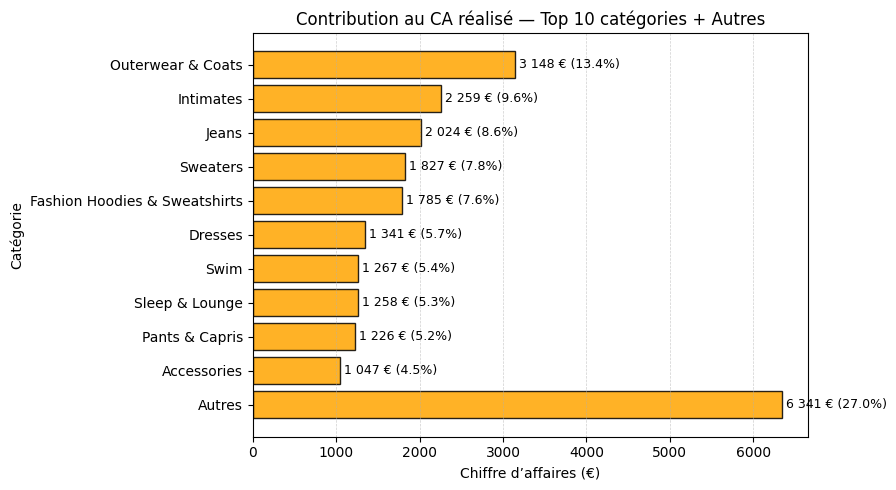

In [62]:
# Paramètre
N = 10

# Agrégation du chiffre d'affaires par catégorie
ca_cat = df_real.groupby("category", observed=False)["sale_price"].sum().sort_values(ascending=False)

# Sélection du Top N et agrégation du reste
top = ca_cat.head(N)
others = ca_cat.iloc[N:].sum()

# Construction de la série finale (Top N + Autres)
series = pd.concat([top, pd.Series({"Autres": others})])

# Calcul des parts relatives
share = (series / series.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="orange", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

# Ajout des annotations (montant + %)
for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center", fontsize=9)

# Mise en forme et affichage
ax.set_title(f"Contribution au CA réalisé — Top {N} catégories + Autres")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Catégorie")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


**Résultat analytique**

Le chiffre d’affaires réalisé est majoritairement généré par un nombre limité de catégories. Outerwear & Coats est le principal contributeur, suivi de Intimates et Jeans, ce qui met en évidence une hiérarchisation nette des familles produit en termes de performance commerciale.

**Implications opérationnelles**

Les catégories leaders constituent les principaux leviers de performance. Les actions prioritaires portent sur :

 - allocation des budgets promotionnels,

 - optimisation du pricing,

 - profondeur/disponibilité des stocks,

 - amélioration de l’expérience sur les pages catégories (navigation, filtres, information de taille).

**Pilotage**

Mettre en place un suivi régulier “CA / marge / taux de marge / retours” sur ces catégories afin d’arbitrer en continu entre objectifs de croissance et de rentabilité.

##### 3.3.3. Contribution par ville

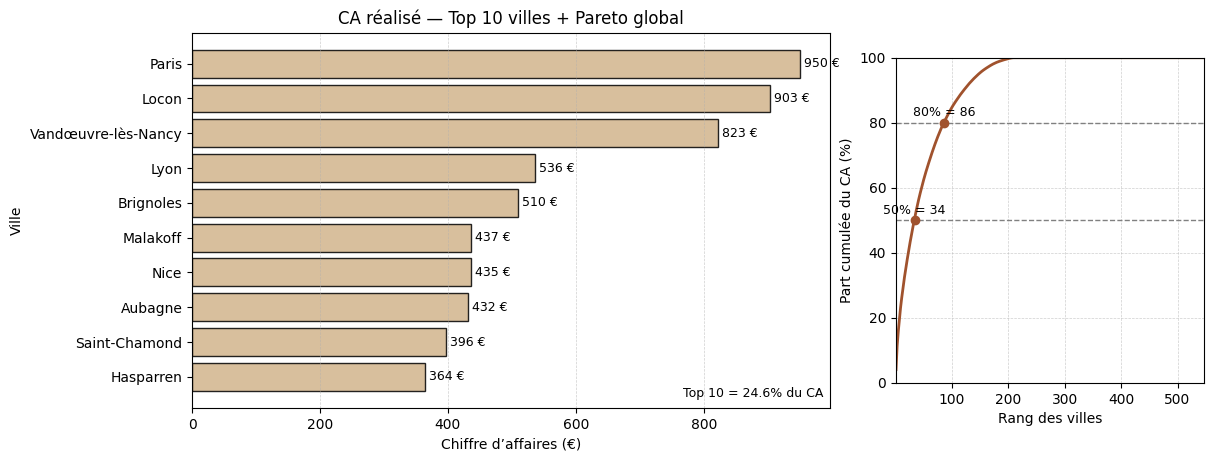

In [63]:
# Paramètre
N = 10

# Agrégation du chiffre d'affaires par ville
ca_city = (
    df_real.groupby("ca_city", observed=False)["sale_price"].sum()
    if "ca_city" in df_real.columns
    else df_real.groupby("city", observed=False)["sale_price"].sum()
).sort_values(ascending=False)

# Total du chiffre d'affaires
total_ca = ca_city.sum()

# Sélection du Top N villes
top = ca_city.head(N).sort_values(ascending=True)

# Part du Top N dans le total
top_share = (top.sum() / total_ca * 100)

# Calcul du Pareto global (toutes villes)
cum_share = (ca_city.cumsum() / total_ca) * 100
ranks = np.arange(1, len(cum_share) + 1)

rank_50 = int(np.argmax(cum_share.values >= 50) + 1)
rank_80 = int(np.argmax(cum_share.values >= 80) + 1)

# Construction du graphique
fig = plt.figure(figsize=(11, 5))

# Affichage du Top N villes
ax = fig.add_axes([0.06, 0.15, 0.58, 0.75])
ax.barh(top.index.astype(str), top.values, color="tan", edgecolor="black", alpha=0.85)

ax.set_title(f"CA réalisé — Top {N} villes + Pareto global")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Ville")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

# Ajout des annotations (montant)
for i, v in enumerate(top.values):
    ax.text(v, i, f" {v:,.0f} €".replace(",", " "), va="center", fontsize=9)

# Annotation de la part du Top N
ax.text(
    0.99, 0.02,
    f"Top {N} = {top_share:.1f}% du CA",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=9
)

# Affichage du Pareto global
axp = fig.add_axes([0.70, 0.20, 0.28, 0.65])
axp.plot(ranks, cum_share.values, color="sienna", linewidth=2)

axp.set_ylim(0, 100)
axp.set_xlim(1, len(ranks))
axp.set_xlabel("Rang des villes")
axp.set_ylabel("Part cumulée du CA (%)")
axp.grid(True, axis="both", linestyle="--", linewidth=0.5, alpha=0.6)

# Ajout des seuils 50% / 80%
axp.axhline(50, color="gray", linestyle="--", linewidth=1)
axp.axhline(80, color="gray", linestyle="--", linewidth=1)

axp.scatter([rank_50, rank_80], [50, 80], color="sienna", zorder=3)
axp.text(rank_50, 52, f"50% = {rank_50}", ha="center", fontsize=9)
axp.text(rank_80, 82, f"80% = {rank_80}", ha="center", fontsize=9)

plt.show()


**Résultat analytique**

Le chiffre d’affaires est géographiquement fragmenté : les 10 premières villes ne représentent qu’environ 24,6 % du CA réalisé. La dispersion est forte : 34 villes sont nécessaires pour atteindre 50 % du CA et 86 villes pour en représenter 80 %, ce qui traduit une longue traîne géographique.

**Implications opérationnelles**

Une stratégie hyper-localisée centrée sur les “Top villes” aurait un impact limité. Les leviers les plus pertinents se situent dans une approche nationale combinant acquisition, expérience utilisateur et qualité du parcours livraison/retour.

**Point de vigilance**

Les indicateurs normalisés (ex. CA par client par ville) doivent être interprétés avec le volume de clients pour éviter les biais liés à de faibles effectifs.

Afin de compléter l’analyse géographique, le chiffre d’affaires est rapporté au nombre de clients par ville afin de neutraliser l’effet de volume.

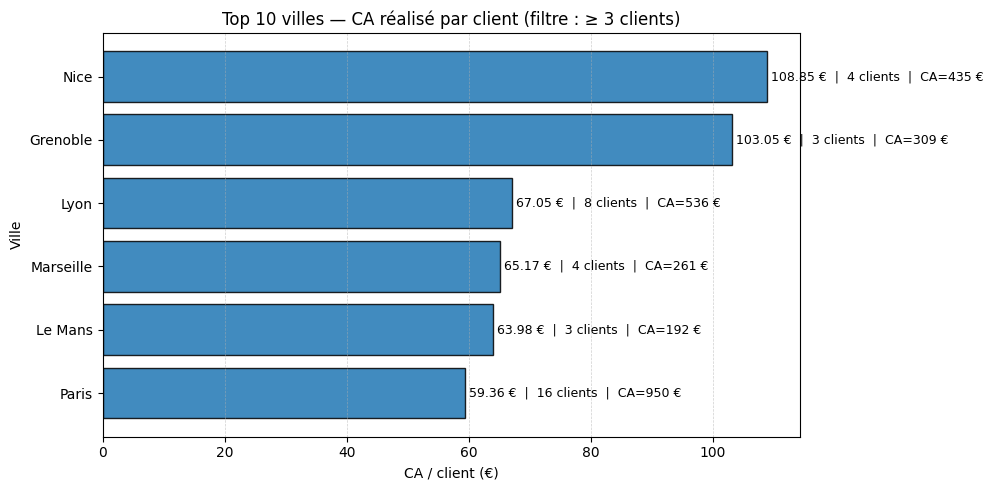

In [65]:
# Paramètres 
N = 10
min_clients = 3

# KPI par ville
city_kpis = (
    df_real.groupby("city", observed=False)
    .agg(
        ca=("sale_price", "sum"),
        clients=("user_id", "nunique"),
        orders=("order_id", "nunique")
    )
)

city_kpis["ca_par_client"] = city_kpis["ca"] / city_kpis["clients"]

# Filtre : villes avec un minimum de clients
city_kpis_f = city_kpis[city_kpis["clients"] >= min_clients].copy()

# Sécurité si trop peu de villes passent le filtre
if city_kpis_f.empty:
    raise ValueError(
        f"Aucune ville ne passe le filtre clients >= {min_clients}. "
        "Baisse min_clients (ex: 5) ou vérifie les données."
    )

# Top N sur CA/client
topN = city_kpis_f.sort_values("ca_par_client", ascending=False).head(N)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(topN.index.astype(str), topN["ca_par_client"].values, edgecolor="black", alpha=0.85)
ax.invert_yaxis()

ax.set_title(f"Top {N} villes — CA réalisé par client (filtre : ≥ {min_clients} clients)")
ax.set_xlabel("CA / client (€)")
ax.set_ylabel("Ville")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

# Annotations : CA/client + nb clients
for i, (v, ncli, ca) in enumerate(zip(topN["ca_par_client"].values, topN["clients"].values, topN["ca"].values)):
    ax.text(
        v,
        i,
        f" {v:.2f} €  |  {ncli} clients  |  CA={ca:,.0f} €".replace(",", " "),
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()



Le classement par chiffre d’affaires moyen par client est filtré sur un minimum de 3 clients afin de limiter les effets de faibles effectifs.
Les premières villes du classement affichent des niveaux élevés de CA/client, mais reposent sur des volumes de clientèle encore limités.
À l’inverse, Paris présente un CA/client plus modéré mais concentre le plus grand nombre de clients et le chiffre d’affaires total le plus élevé.
Cet indicateur est donc interprété comme un signal exploratoire, à croiser systématiquement avec le volume de clients pour les décisions opérationnelles.

##### 3.3.4. Contribution par saisonnalité mensuelle

Nous allons maintenant créer une colonne month pour analyser la saisonnalité mensuelle. La saisonnalité mensuelle est analysée en agrégeant les ventes des années 2023 et 2024 afin de faire ressortir le profil saisonnier global du périmètre étudié.

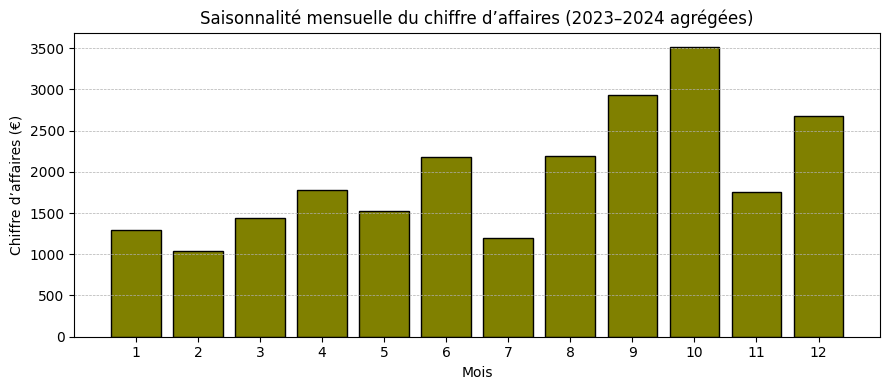

In [18]:
# Création colonne mois pour df_real
df_real["month"] = df_real["item_created_at"].dt.month

# Agrégation mensuelle du chiffre d'affaires
seasonality = (
    df_real.groupby("month")["sale_price"]
       .sum()
       .reindex(range(1, 13), fill_value=0)
)

# Construction du bar chart
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(seasonality.index, seasonality.values, color="olive", edgecolor="black")

# Mise en forme et affichage
ax.set_xticks(range(1, 13))
ax.set_title("Saisonnalité mensuelle du chiffre d’affaires (2023–2024 agrégées)")
ax.set_xlabel("Mois")
ax.set_ylabel("Chiffre d’affaires (€)")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


**Résultat analytique**

L’agrégation des ventes réalisées sur 2023 et 2024 met en évidence une saisonnalité intra-annuelle : certains mois concentrent systématiquement davantage de chiffre d’affaires (notamment en fin d’année), ce qui reflète un profil saisonnier structurel sur le périmètre.

**Implications opérationnelles**

Cette saisonnalité sert principalement à planifier : ajustement des stocks, préparation des campagnes marketing et calibration de la pression promotionnelle en amont des périodes de pic.

**Point de vigilance**

La saisonnalité agrégée n’explique pas la croissance 2023 vs 2024 : l’analyse des écarts inter-annuels doit se faire via une comparaison mois par mois des deux années.

#### 3.4 Analyse de la marge et de la rentabilité

##### 3.4.1. Marge unitaire – distribution

Après avoir analysé la structure des prix et des coûts, puis la contribution au chiffre d’affaires, cette section vise à étudier la rentabilité du périmètre à travers l’analyse de la marge et du taux de marge, afin d’identifier les segments créateurs de valeur. Dans ce projet, la marge (ou marge brute) est définie comme sale_price – cost au niveau ligne.

In [69]:
# Création des métriques de marge
df_real["marge"] = df_real["sale_price"] - df_real["cost"]
df_real["taux_marge"] = df_real["marge"] / df_real["sale_price"]

# Statistiques descriptives
df_real[["marge", "taux_marge"]].describe()

,marge,taux_marge
count,425.000000,425.000000
mean,28.729295,0.512527
std,38.437359,0.067113
min,1.070160,0.350000
25%,9.450090,0.460000
50%,18.468000,0.514000
75%,31.297000,0.568000
max,465.947999,0.669000


La distribution des marges unitaires est asymétrique, avec une majorité d’articles générant une marge modérée et une longue traîne de produits à forte contribution. Le taux de marge moyen est cohérent avec le taux global observé (~52 %), confirmant la qualité des données de coût.

##### 3.4.2. Contribution à la marge totale par catégorie

Après avoir analysé la distribution globale des marges unitaires, cette section vise à identifier les catégories de produits qui contribuent le plus à la marge totale du périmètre. L’objectif est de comparer cette hiérarchisation à celle observée pour le chiffre d’affaires, afin de détecter d’éventuels effets de mix ou de rentabilité différenciée selon les familles de produits.

In [70]:
# Marge totale par catégorie
marge_cat = (
    df_real
    .groupby("category", observed=False)["marge"]
    .sum()
    .sort_values(ascending=False)
)

# Top 10 + autres
top = marge_cat.head(10)
others = marge_cat.iloc[10:].sum()
series = pd.concat([top, pd.Series({"Autres": others})])

# Parts relatives
share = (series / series.sum() * 100).round(1)


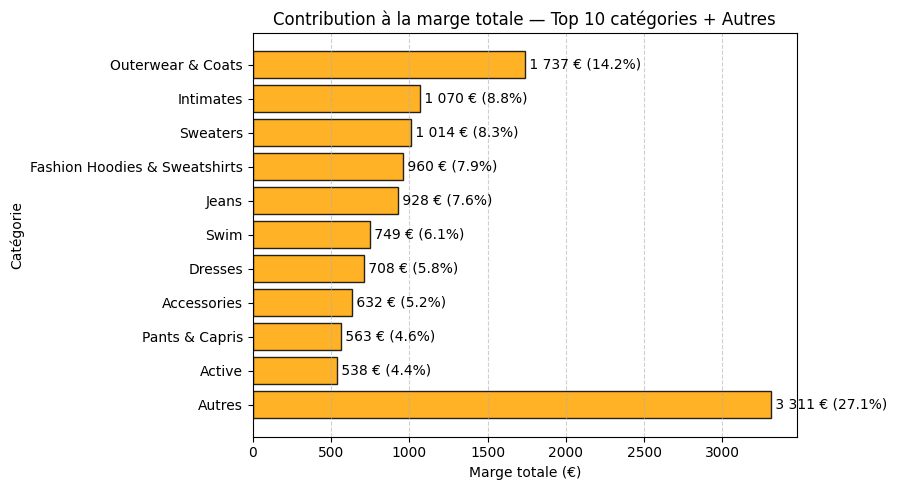

In [71]:
# Plot Contribution à la marge totale par catégorie

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="orange", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center")

ax.set_title("Contribution à la marge totale — Top 10 catégories + Autres")
ax.set_xlabel("Marge totale (€)")
ax.set_ylabel("Catégorie")
ax.grid(True, axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

**Résultat analytique**

La marge totale est principalement portée par les mêmes catégories que le chiffre d’affaires (Outerwear & Coats, Intimates, Jeans). Le bloc “Autres” reste significatif, indiquant qu’une part non négligeable de la marge est répartie sur des catégories secondaires.

**Implications opérationnelles**

Les catégories à forte marge totale doivent concentrer les efforts (assortiment, pricing, mise en avant) car elles représentent des leviers “volume rentable”.

**Point de vigilance**

La marge totale est corrélée au volume : elle ne permet pas d’identifier à elle seule les catégories structurellement les plus rentables (ce rôle revient au taux de marge).

##### 3.4.3. Taux de marge par catégorie

Après avoir analysé la contribution absolue des catégories à la marge totale, cette section vise à neutraliser l’effet de volume afin d’évaluer la rentabilité relative des différentes familles de produits. L’objectif est d’identifier les catégories structurellement plus rentables, indépendamment de leur poids dans le chiffre d’affaires ou la marge globale.

In [72]:
# Taux de marge par catégorie

taux_marge_cat = (
    df_real
    .groupby("category", observed=False)
    .agg(
        marge_totale=("marge", "sum"),
        ca_total=("sale_price", "sum")
    )
)

taux_marge_cat["taux_marge"] = (
    taux_marge_cat["marge_totale"] / taux_marge_cat["ca_total"]
)

taux_marge_cat = taux_marge_cat["taux_marge"].sort_values(ascending=False)

taux_marge_cat.head(10)

category
Blazers & Jackets                0.618261
Accessories                      0.603458
Skirts                           0.603390
Swim                             0.590816
Socks & Hosiery                  0.589802
Active                           0.559270
Sweaters                         0.554881
Maternity                        0.553222
Outerwear & Coats                0.551908
Fashion Hoodies & Sweatshirts    0.538050
Name: taux_marge, dtype: float64

**Résultat analytique**
Les taux de marge varient fortement selon les catégories : certaines familles présentent une rentabilité relative plus élevée, indépendamment de leur poids en chiffre d’affaires.

**Implications opérationnelles**
Les catégories à taux de marge élevé mais faible volume constituent des leviers d’optimisation : tests de mise en avant, cross-sell et extension contrôlée de l’assortiment pour augmenter leur contribution sans dégrader le mix.

**Pilotage**
Lecture croisée recommandée :

 - marge totale = levier “volume rentable”,

 - taux de marge = levier “rentabilité relative”.

### 4. Comparaison 2023 vs 2024

A présent, voyons l'évolution mensuelle des ventes sur les années 2023 et 2024. L’analyse mensuelle permet de mettre en évidence la saisonnalité et d’identifier les périodes qui contribuent le plus aux écarts de performance entre 2023 et 2024. Comme avant, les analyses portent exclusivement sur les lignes de vente finalisées (statut "Complete"), afin de décrire la performance e-commerce réellement réalisée sur le périmètre.

Toutes les analyses temporelles comparatives 2023 vs 2024 seront basées sur item_created_at (date des lignes) comme vu auparavant.

In [23]:
# Evaluation du CA par année
df_real.groupby("year")["sale_price"].sum()

year
2023     7806.319998
2024    15716.280016
Name: sale_price, dtype: float64

Tout d'abord on remarque rapidement que ce chiffre d'affaires réalisé a significativement augmenté en 2024 par rapport à 2023. Regardons à présent le détail mois par mois.

In [24]:
# Création du dataframe regroupant les ventes par mois et années
monthly_ca = (
    df_real.groupby(["year", "month"])["sale_price"]
    .sum()
    .reset_index()
)

# Basculement du dataframe regroupant les ventes par mois et années
monthly_ca_pivot = monthly_ca.pivot(
    index="month",
    columns="year",
    values="sale_price"
)
monthly_ca_pivot

year,2023,2024
month,,
1,379.060003,920.759998
2,273.110003,771.389997
3,282.139999,1153.249990
4,743.299998,1031.020017
5,641.709999,880.730000
6,447.300000,1732.519998
7,384.859993,812.279997
8,863.260000,1332.590012
9,1169.070000,1761.389992


Nous avons une table représentant l'évolution mensuelle des ventes. Nous pouvons rajouter le différentiel mois à mois entre les deux années.

In [25]:
# Ajout de la variation absolue de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_abs"] = (
    monthly_ca_pivot[2024]
    - monthly_ca_pivot[2023]
)

# Ajout de la variation relative de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_pct"] = (
    (monthly_ca_pivot[2024] - monthly_ca_pivot[2023])
    / monthly_ca_pivot[2023]
)

monthly_ca_pivot

year,2023,2024,delta_abs,delta_pct
month,,,,
1,379.060003,920.759998,541.699995,1.429061
2,273.110003,771.389997,498.279994,1.824466
3,282.139999,1153.249990,871.109990,3.087510
4,743.299998,1031.020017,287.720018,0.387085
5,641.709999,880.730000,239.020001,0.372474
6,447.300000,1732.519998,1285.219998,2.873284
7,384.859993,812.279997,427.420004,1.110586
8,863.260000,1332.590012,469.330011,0.543672
9,1169.070000,1761.389992,592.319992,0.506659


Il serait maintenant intéressant d'afficher le tout sur un graphe de manière à mieux visualiser les pics ou creux, en ajoutant le volume de commandes finalisées.

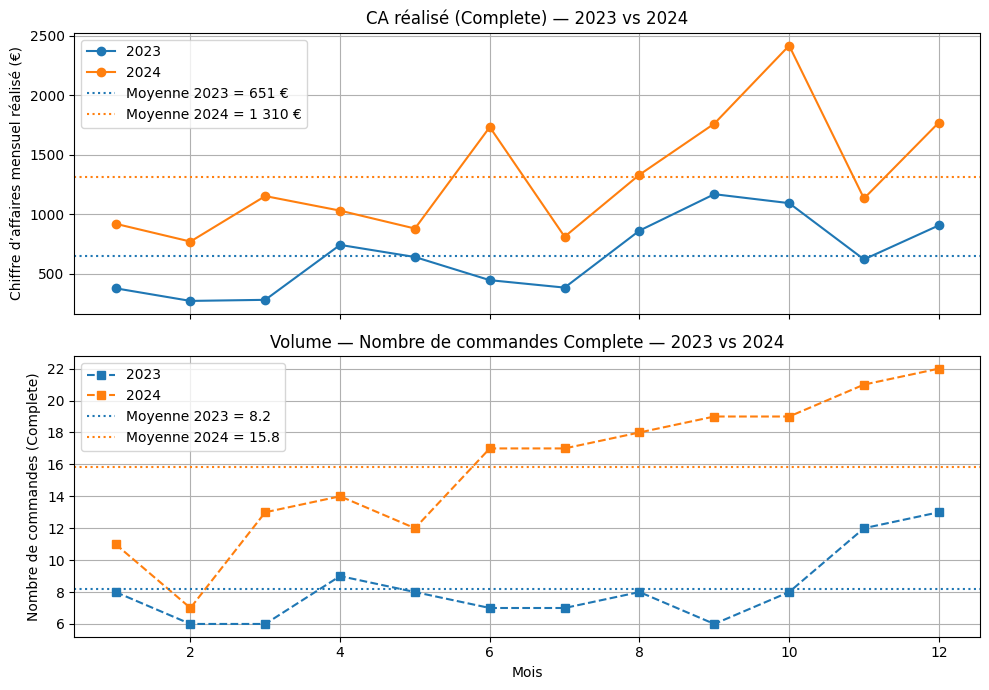

In [79]:
YEARS = [2023, 2024]

# CA mensuel
monthly_ca = (
    df_real.groupby(["year", "month"])["sale_price"]
    .sum()
    .reset_index(name="ca")
)

monthly_ca_pivot = (
    monthly_ca.pivot(index="month", columns="year", values="ca")
    .reindex(range(1, 13), fill_value=0)
)

# Volume de commandes mensuel
monthly_orders = (
    df_real.groupby(["year", "month"])["order_id"]
    .nunique()
    .reset_index(name="nb_orders")
)

monthly_orders_pivot = (
    monthly_orders.pivot(index="month", columns="year", values="nb_orders")
    .reindex(range(1, 13), fill_value=0)
)

# Années réellement présentes (évite les KeyError et les graphiques à 1 seule courbe)
years_ca = [y for y in YEARS if y in monthly_ca_pivot.columns]
years_orders = [y for y in YEARS if y in monthly_orders_pivot.columns]

# Plot : 2 graphes empilés
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# CA
monthly_ca_pivot[years_ca].plot(ax=axes[0], kind="line", marker="o")
axes[0].set_title("CA réalisé (Complete) — 2023 vs 2024")
axes[0].set_ylabel("Chiffre d’affaires mensuel réalisé (€)")
axes[0].grid(True)

# Couleurs des courbes CA
line_colors_ca = {int(line.get_label()): line.get_color() for line in axes[0].lines if line.get_label().isdigit()}
for y in years_ca:
    mean_y = monthly_ca_pivot[y].mean()
    axes[0].axhline(
        mean_y,
        linestyle=":",
        linewidth=1.5,
        color=line_colors_ca.get(y, None),
        label=f"Moyenne {y} = {mean_y:,.0f} €".replace(",", " ")
    )
axes[0].legend()

# Volume commandes
monthly_orders_pivot[years_orders].plot(ax=axes[1], kind="line", marker="s", linestyle="--")
axes[1].set_title("Volume — Nombre de commandes Complete — 2023 vs 2024")
axes[1].set_xlabel("Mois")
axes[1].set_ylabel("Nombre de commandes (Complete)")
axes[1].grid(True)

# Couleurs des courbes volume
line_colors_orders = {int(line.get_label()): line.get_color() for line in axes[1].lines if line.get_label().isdigit()}
for y in years_orders:
    mean_y = monthly_orders_pivot[y].mean()
    axes[1].axhline(
        mean_y,
        linestyle=":",
        linewidth=1.5,
        color=line_colors_orders.get(y, None),
        label=f"Moyenne {y} = {mean_y:.1f}"
    )
axes[1].legend()

plt.tight_layout()
plt.show()


La comparaison mensuelle du chiffre d’affaires réalisé et du nombre de commandes finalisées met en évidence une dynamique plus favorable en 2024 qu’en 2023. Sur la majorité des mois, le chiffre d’affaires et le nombre de commandes au statut "Complete" évoluent dans le même sens, traduisant une progression conjointe de ces deux indicateurs sur la période.

Des écarts ponctuels entre les courbes sont observés sur certains mois, sans que leur origine puisse être établie à ce stade de l’analyse. Ces constats motivent le calcul des indicateurs normalisés (panier moyen, marge, retours) dans la section KPI afin de préciser les leviers sous-jacents à l’évolution 2023 vs 2024.

**Synthèse de l’EDA**

Cette analyse exploratoire met en évidence sur le périmètre étudié :
- des différences marquées entre 2023 et 2024,
- une structuration du chiffre d’affaires autour de certains segments produits,
- des dynamiques temporelles marquées et une répartition géographique fragmentée.

Globalement, la performance 2024 s’explique surtout par le volume de commandes finalisées. Les leviers actionnables se concentrent sur : (1) le pilotage des catégories clés (CA + marge), (2) la réduction des retours sur les catégories à fort volume, et (3) l’optimisation du catalogue en longue traîne (marques/villes), via merchandising, disponibilité et expérience logistique.

Après cette phase exploratoire, les indicateurs clés sont maintenant calculés de manière formalisée, selon des définitions métier explicites, afin de permettre une comparaison robuste entre 2023 et 2024 et une reprise directe dans le reporting.


### 5. KPI Python

Pour conclure l’EDA Python, nous calculons et présentons quelques indicateurs clés de la performance globale.
Comme avant, nous parlerons de CA réalisé. C’est-à-dire que les lignes de commande au statut autre que "Complete" seront exclues du calcul.

### Chiffre d’affaires réalisé (€) : 
Somme des sale_price des lignes au statut "Complete".

In [27]:
# Calcul du chiffre d'affaires
ventes = df[df["item_status"] == "Complete"]
ca_total = ventes.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7806.32 €
 2024 : 15716.28 €


### Marge brute (€) : 
Somme des sale_price – cost des lignes au statut "Complete".

In [28]:
# Calcul de la marge brute
cost_total = ventes.groupby("year")["cost"].sum()
marge_brute = ca_total - cost_total

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 4075.34 €
2024 : 8134.61 €


### Panier moyen (€) :
Afin de contextualiser l’interprétation du panier moyen, un contrôle préalable est réalisé sur la structure des commandes. Le panier moyen étant calculé à l’échelle de la commande (`order_id`), il est utile de comprendre combien d’articles composent généralement une commande.

In [29]:
# Nombre de lignes par commande
items_per_order = df.groupby("order_id")["order_item_id"].count()
items_per_order.describe()

count    1117.000000
mean        1.503133
std         0.848380
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: order_item_id, dtype: float64

La distribution du nombre de lignes par commande montre que la majorité des commandes contient un seul article (médiane = 1), avec une proportion plus limitée de commandes multi-articles (75 % ≤ 2 articles, maximum observé = 4). Cette structure implique que les variations de panier moyen proviennent principalement du prix moyen par article, plutôt que d’un effet quantité.

Par ailleurs, les statuts sont homogènes au sein des commandes sur ce fichier, ce qui permet d’interpréter les ventes “Complete” directement au niveau commande sans ambiguïté méthodologique.



In [31]:
# Filtre sur les ventes réalisées
sales = df[df["item_status"] == "Complete"].copy()

# Chiffre d'affaires réalisé par année
ca = sales.groupby("year")["sale_price"].sum()

# Nombre de commandes distinctes ayant généré du revenu
nb_orders = sales.groupby("year")["order_id"].nunique()

# Calcul du panier moyen et arrondi au centime
panier_moyen = (ca / nb_orders).round(2)

# Affichage du panier moyen
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 80.48 €
2024 : 85.41 €


Le panier moyen progresse légèrement entre 2023 et 2024 (de 80,48 € à 85,41 €). Toutefois, cette hausse reste limitée au regard de la croissance du chiffre d’affaires, ce qui suggère que l’augmentation du CA est principalement expliquée par le volume (plus de commandes finalisées), plutôt que par une hausse marquée de la valeur moyenne par commande, dans la mesure où CA = nb commandes × panier moyen.

### Taux de retour (%) :
Le taux de retour est défini comme la proportion de lignes retournées parmi les lignes effectivement vendues.
Une ligne est considérée comme vendue si son statut est "Complete" ; les lignes au statut "Returned" correspondent à des ventes ayant fait l’objet d’un retour.
Les statuts "Processing", "Shipped" et "Cancelled" sont exclus du calcul car ils ne garantissent pas la réalisation effective du revenu.
Le calcul est effectué au grain ligne de commande (order_item).

In [32]:
# Lignes vendues + retournées
ventes_retour = df[df["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an = (
    ventes_retour.assign(is_return=ventes_retour["item_status"] == "Returned")
    .groupby("year")["is_return"]
    .mean()
)

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 37.87 %
2024 : 30.42 %


Le taux de retour observé sur le périmètre étudié est relativement élevé, en particulier en 2023, ce qui constitue un point de vigilance pour l’activité e-commerce. Les retours ont un impact direct sur la rentabilité opérationnelle (coûts logistiques, gestion des stocks, dépréciation potentielle des articles).

La baisse du taux de retour observée entre 2023 et 2024 suggère une amélioration de la qualité des ventes ou du mix produit sur la période, sans que l’EDA ne permette d’en identifier précisément les leviers. Ce taux agrégé appelle donc une analyse complémentaire par catégorie de produits afin d’identifier les segments structurellement plus exposés aux retours.


In [33]:
# Taux de retour par catégorie
retours_cat = (
    df[df["item_status"].isin(["Complete", "Returned"])]
    .assign(is_return=lambda x: x["item_status"] == "Returned")
    .groupby("category", observed=False)
    .agg(
        lignes=("is_return", "count"),
        retours=("is_return", "sum")
    )
)

retours_cat["taux_retour"] = retours_cat["retours"] / retours_cat["lignes"]
retours_cat.sort_values("taux_retour", ascending=False).head(10)


,lignes,retours,taux_retour
category,,,
Clothing Sets,1,1,1.000000
Suits,5,3,0.600000
Blazers & Jackets,20,11,0.550000
Tops & Tees,38,18,0.473684
Outerwear & Coats,25,11,0.440000
Shorts,28,11,0.392857
Dresses,31,12,0.387097
Skirts,16,6,0.375000
Socks & Hosiery,27,10,0.370370


Le taux de retour global masque de fortes disparités entre catégories.
Certaines catégories affichent des taux très élevés, mais sur des volumes faibles.
En revanche, des catégories à fort volume comme Tops & Tees ou Outerwear & Coats combinent un poids significatif et un taux de retour supérieur à la moyenne, ce qui en fait des priorités de pilotage.
Cela justifie une approche ciblée par catégorie plutôt qu’une action globale.


Limite méthodologique : Ce taux élevé doit être interprété avec prudence, le fichier CSV pédagogique ne garantissant pas l’exhaustivité des retours ni la complétude de l’historique client.

### Taux de ré‑achat (%) : 
Le taux de ré-achat est défini comme la part des clients ayant passé **au moins deux commandes distinctes génératrices de revenu sur une même année**.  
Une commande est comptabilisée dans une année dès lors qu’elle contient **au moins une ligne au statut "Complete"** sur cette année.

Cet indicateur est calculé au grain client, à partir des lignes de vente effectivement réalisées (statut "Complete"), et constitue un indicateur clé de fidélisation.



In [34]:
# Lignes de vente (Complete) sur le périmètre
sales = df[df["item_status"] == "Complete"].copy()

# Nombre de commandes valides par client et par année
nb_orders_per_user_year = (
    sales.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders = nb_orders_per_user_year.loc[year]  # série indexée par user_id
    taux_reachat = (nb_orders >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat:.2f} %")


Taux de ré-achat 2023 : 0.00 %
Taux de ré-achat 2024 : 3.39 %


Le calcul du taux de ré-achat effectué sur le fichier CSV fourni aboutit à un taux nul en 2023. Ce résultat apparaît peu plausible d’un point de vue métier et constitue un **signal d’alerte sur l’exhaustivité de l’historique client** disponible dans ce fichier.

Le taux de ré-achat étant particulièrement sensible à la complétude des données clients (historique de commandes, stabilité des identifiants), cette anomalie suggère une **perte ou une limitation de l’historique** dans le périmètre du CSV pédagogique.


**Note méthodologique — source des indicateurs** :

Le fichier CSV pédagogique est utilisé exclusivement pour l’analyse exploratoire (EDA) et la compréhension des dynamiques générales.
Les indicateurs de performance retenus pour le reporting et le dashboard sont recalculés à partir d’un export reconstruit depuis BigQuery, considéré comme la source de vérité, et aligné avec les requêtes SQL du projet.

### 6. KPI Python du nouveau dataset extrait de BigQuery

Des écarts apparaissent entre les KPI calculés à partir du CSV fourni et ceux recalculés à partir d’un export reconstruit depuis BigQuery (source de vérité). Ces différences s’expliquent par de légères variations de périmètre effectif entre les deux jeux de données (logique de jointures, stabilité de l’extraction, filtres temporels appliqués au grain “ligne” vs “commande”, et présence/absence de certaines lignes).

Afin de sécuriser les indicateurs, les KPI ont donc été recalculés en Python sur un export BigQuery construit avec les mêmes filtres que les requêtes SQL. Les valeurs issues de cet export sont retenues comme référence pour la suite du projet et pour l’alimentation du dashboard Power BI.

In [35]:
# Chargement du fichier csv
df_bq = pd.read_csv("../sql/data/csv_BigQuery.csv")

# Dimensions du jeu de données
print(f'Le jeu de données fait {df_bq.shape[0]} lignes et {df_bq.shape[1]} colonnes')

# En-tête du jeu de données
df_bq.head()

Le jeu de données fait 1591 lignes et 17 colonnes


,order_id,order_item_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,user_id,gender,country,state,city
0,61125,88932,2023-01-01 08:54:29.000000 UTC,Shipped,198.000000,97.614000,Jeans,Women,Diesel,Diesel Women's Louvboot Slim Flare Jean,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
1,61125,88931,2023-01-02 08:44:55.000000 UTC,Shipped,42.990002,22.741711,Pants & Capris,Women,LOTUSTRADERS,BLACK PANT GAUCHOS RUFFLE TIERS WIDE - FITS (O...,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
2,61125,88930,2023-01-03 11:57:34.000000 UTC,Shipped,65.000000,35.620000,Shorts,Women,KUT from the Kloth,KUT from the Kloth Women's Bermuda Trouser Short,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
3,6107,8932,2023-01-06 23:35:33.000000 UTC,Processing,12.990000,6.533970,Plus,Women,Scarf_tradinginc,Scarf_tradinginc Elegant Paisley Jacquard Pash...,Processing,2023-01-07 00:17:39.000000 UTC,4905,F,France,Grand Est,Laxou
4,101416,147699,2023-01-07 21:33:19.000000 UTC,Shipped,45.000000,25.920000,Intimates,Women,By The Sword Inc.,Renaissance Classic Chemise,Shipped,2023-01-06 22:16:57.000000 UTC,80975,F,France,Provence-Alpes-Côte d'Azur,Marseille


On type les colonnes date comme pour le CSV d'origine.

In [36]:
# Colonnes de date 
col_dates_bq = ["item_created_at", "order_created_at"]

# Formatage de la date 
for c in col_dates_bq:
    dates2 = pd.to_datetime(df_bq[c], errors='coerce')
    df_bq[c] = dates2

# Colonnes année et mois 
df_bq["year"] = df_bq["item_created_at"].dt.year
df_bq["month"] = df_bq["item_created_at"].dt.month

### Chiffre d’affaires réalisé - BigQuery (€) : 
Somme des sale_price des lignes au statut "Complete".

In [37]:
# Calcul du chiffre d'affaires
ventes_bq = df_bq[df_bq["item_status"] == "Complete"]
ca_total_bq = ventes_bq.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total_bq.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7065.42 €
 2024 : 14137.46 €


*CA : **+100.1%****

### Marge brute (€) - BigQuery : 
Somme des sale_price – cost des lignes au statut "Complete".

In [38]:
# Calcul de la marge brute
cost_total_bq = ventes_bq.groupby("year")["cost"].sum()
marge_brute_bq = ca_total_bq - cost_total_bq

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute_bq.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 3647.46 €
2024 : 7409.43 €


*Marge brute : **+103.1%****

### Panier moyen (€) - BigQuery :
Afin de contextualiser l’interprétation du panier moyen, un contrôle préalable est réalisé sur la structure des commandes.  
Le panier moyen étant calculé à l’échelle de la commande (`order_id`), il est nécessaire de comprendre combien d’articles composent généralement une commande et si la structure des statuts peut influencer cet indicateur.

In [39]:
# Nombre de lignes par commande
items_per_order_bq = df_bq.groupby("order_id")["order_item_id"].count()
items_per_order_bq.describe()

count    1053.000000
mean        1.510921
std         0.864995
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: order_item_id, dtype: float64

In [40]:
# Nombre de statuts distincts par commande
df_bq.groupby("order_id")["item_status"].nunique().value_counts()

item_status
1    1053
Name: count, dtype: int64

Comme pour le fichier CSV, la distribution du nombre de lignes par commande montre que la majorité des commandes contient un seul article (médiane = 1), avec une proportion limitée de commandes multi-articles (75 % ≤ 2 articles). Le panier moyen n’est donc pas tiré par des commandes exceptionnellement volumineuses.

Sur l’extrait BigQuery analysé, chaque commande présente un statut unique au niveau de ses lignes (constat empirique sur le périmètre). Par convention de calcul et afin de rester robuste si cette propriété ne tenait pas dans d’autres extractions, une commande est considérée comme génératrice de revenu dès lors qu’elle contient au moins une ligne au statut “Complete” sur l’année considérée. Le chiffre d’affaires reste défini comme la somme des lignes “Complete”.

In [41]:
# Filtre sur les ventes réalisées
sales_bq = df_bq[df_bq["item_status"] == "Complete"].copy()

# Chiffre d'affaires réalisé par année
ca_bq = sales_bq.groupby("year")["sale_price"].sum()

# Nombre de commandes distinctes ayant généré du revenu
nb_orders_bq = sales_bq.groupby("year")["order_id"].nunique()

# Calcul du panier moyen et arrondi au centime
panier_moyen_bq = (ca_bq / nb_orders_bq).round(2)

# Affichage du panier moyen
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen_bq.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 85.13 €
2024 : 86.73 €


*Panier moyen : **+1.9%***

Le panier moyen progresse légèrement entre 2023 et 2024 tandis que la croissance du chiffre d’affaires et de la marge augmentent fortement. Dans la mesure où CA = nb commandes × panier moyen, cela suggère que l’augmentation du CA est principalement expliquée par le volume (plus de commandes finalisées), plutôt que par une hausse marquée de la valeur moyenne par commande. 

### Taux de retour - BigQuery (%) :
Le taux de retour est défini comme la proportion de lignes retournées parmi les lignes effectivement vendues.
Une ligne est considérée comme vendue si son statut est "Complete" ; les lignes au statut "Returned" correspondent à des ventes ayant fait l’objet d’un retour.
Les statuts "Processing", "Shipped" et "Cancelled" sont exclus du calcul car ils ne garantissent pas la réalisation effective du revenu.
Le calcul est effectué au grain ligne de commande (order_item).

In [42]:
# Lignes vendues + retournées
ventes_retour_bq = df_bq[df_bq["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an_bq = (ventes_retour_bq.assign(is_return=ventes_retour_bq["item_status"] == "Returned").groupby("year")["is_return"].mean())

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an_bq.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 25.30 %
2024 : 24.69 %


*Taux de retour : **-0.61 pt***

Le taux de retour recalculé à partir de l’export BigQuery apparaît sensiblement plus modéré que celui observé sur le fichier CSV pédagogique, avec des niveaux proches entre 2023 et 2024. Ce résultat confirme que les valeurs élevées initialement observées étaient en partie liées à des effets de périmètre ou d’exhaustivité des données dans le fichier CSV.

Néanmoins, un taux de retour proche de 25 % reste significatif dans un contexte e-commerce, compte tenu de son impact direct sur la rentabilité opérationnelle (coûts logistiques, gestion des stocks, dépréciation potentielle des articles). La légère baisse observée entre 2023 et 2024 suggère une amélioration marginale de la qualité des ventes ou du mix produit, sans que l’analyse agrégée ne permette d’en identifier précisément les leviers.

Ces résultats justifient la poursuite de l’analyse par catégorie de produits afin d’identifier les segments structurellement plus exposés aux retours et d’éclairer les décisions d’assortiment et de pilotage.

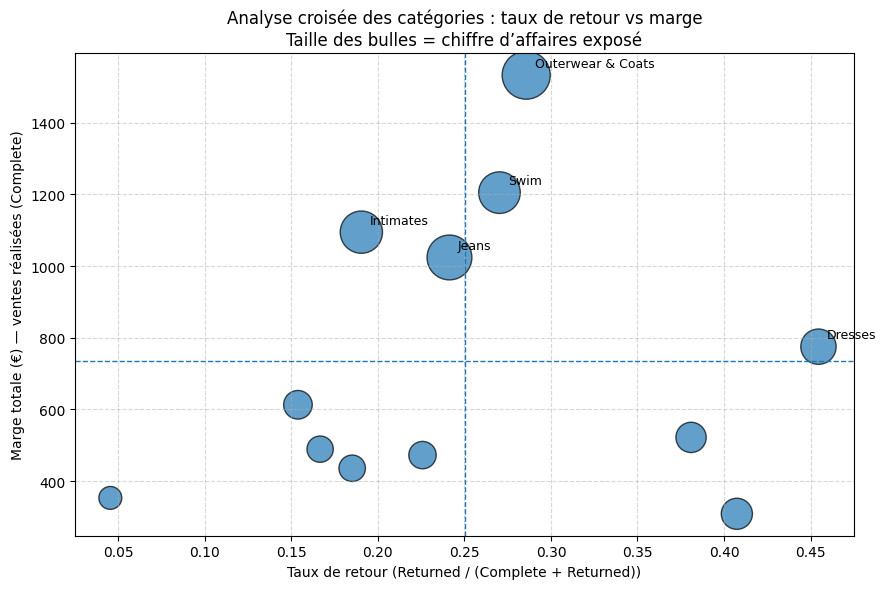

,lignes,retours,taux_retour,ca_expose,ca_realise,marge_totale
category,,,,,,
Outerwear & Coats,21,6,0.285714,3638.420015,2797.070017,1533.073141
Jeans,29,7,0.241379,3167.199995,2219.999998,1024.140461
Intimates,84,16,0.190476,2813.100008,2309.320005,1094.830224
Swim,37,10,0.270270,2726.970001,2090.629999,1205.160627
Dresses,22,10,0.454545,1968.299997,1375.830001,775.111421
Sleep & Lounge,27,11,0.407407,1525.700003,804.930006,308.581241
Sweaters,21,8,0.380952,1443.750010,951.790007,521.831714
Maternity,26,4,0.153846,1289.620001,1087.690001,612.906778
Fashion Hoodies & Sweatshirts,31,7,0.225806,1182.780003,908.470005,472.422852


In [98]:
# ============================================================
# Analyse croisée (catégorie) : taux de retour × marge
# - X : taux de retour (Returned / (Complete + Returned))
# - Y : marge totale (€) sur ventes réalisées (Complete)
# - Taille : CA exposé (Complete + Returned)
# Objectif : prioriser les catégories à fort enjeu économique
# ============================================================

# --- 1) Base retours : lignes vendues + retournées uniquement ---
base = df_bq[df_bq["item_status"].isin(["Complete", "Returned"])].copy()
base["is_return"] = base["item_status"] == "Returned"  # indicateur binaire de retour

# --- 2) KPI retours par catégorie (diagnostic + volume) ---
retours_cat = (
    base.groupby("category", observed=False)
    .agg(
        lignes=("is_return", "count"),          # volume total (Complete + Returned)
        retours=("is_return", "sum"),           # nombre de lignes retournées
        commandes=("order_id", "nunique"),      # nombre de commandes concernées
        ca_expose=("sale_price", "sum"),        # CA mis en jeu avant retours
        ca_retourne=("sale_price",              # montant effectivement retourné
                     lambda x: x[base.loc[x.index, "item_status"] == "Returned"].sum())
    )
)

# Taux de retour par catégorie
retours_cat["taux_retour"] = retours_cat["retours"] / retours_cat["lignes"]

# --- 3) Filtre volume (anti biais faibles effectifs) ---
MIN_LIGNES = 20
retours_cat_f = retours_cat[retours_cat["lignes"] >= MIN_LIGNES].copy()

# --- 4) KPI marge par catégorie (ventes réalisées uniquement : Complete) ---
complete = df_bq[df_bq["item_status"] == "Complete"].copy()
complete["marge"] = complete["sale_price"] - complete["cost"]  # marge unitaire

marge_cat = (
    complete.groupby("category", observed=False)
    .agg(
        ca_realise=("sale_price", "sum"),       # CA réalisé
        marge_totale=("marge", "sum")           # marge totale (€)
    )
)

# --- 5) Table finale (retours + marge) ---
scatter_df = (
    retours_cat_f
    .join(marge_cat, how="left")               # jointure au niveau catégorie
    .replace([np.inf, -np.inf], np.nan)        # sécurisation divisions par zéro
    .dropna(subset=["taux_retour", "marge_totale"])
)

# --- 6) Scatter : taux de retour (X) vs marge (€) (Y) ---
# Taille des bulles : CA exposé (normalisé pour lisibilité)
sizes = (scatter_df["ca_expose"] / scatter_df["ca_expose"].max()) * 1200
sizes = sizes.clip(lower=80)

plt.figure(figsize=(9, 6))
plt.scatter(
    scatter_df["taux_retour"],                 # X = taux de retour
    scatter_df["marge_totale"],                # Y = marge (€)
    s=sizes,
    alpha=0.7,
    edgecolor="black"
)

# Lignes de référence (moyennes) pour lecture en quadrants
x_ref = scatter_df["taux_retour"].mean()
y_ref = scatter_df["marge_totale"].mean()
plt.axvline(x_ref, linestyle="--", linewidth=1)
plt.axhline(y_ref, linestyle="--", linewidth=1)

# Annotation des catégories à plus fort enjeu (top CA exposé)
top = scatter_df.sort_values("ca_expose", ascending=False).head(5)
for cat in top.index:
    plt.annotate(
        str(cat),
        (scatter_df.loc[cat, "taux_retour"],
         scatter_df.loc[cat, "marge_totale"]),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=9
    )

plt.xlabel("Taux de retour (Returned / (Complete + Returned))")
plt.ylabel("Marge totale (€) — ventes réalisées (Complete)")
plt.title(
    "Analyse croisée des catégories : taux de retour vs marge\n"
    "Taille des bulles = chiffre d’affaires exposé"
)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 7) Tableau support pour commenter le graphique ---
scatter_df.sort_values("ca_expose", ascending=False)[
    [
        "lignes",
        "retours",
        "taux_retour",
        "ca_expose",
        "ca_realise",
        "marge_totale"
    ]
].head(10)


**Résultat analytique**

Le scatter taux de retour vs marge met en évidence que les catégories ne doivent pas être priorisées uniquement sur leur taux de retour, mais sur le couple “enjeu économique + risque retour”, matérialisé par la marge (axe Y) et le CA exposé (taille des bulles).

Trois catégories ressortent comme priorités n°1 car elles combinent forte marge et CA exposé important, avec un taux de retour supérieur / proche de la moyenne :

 - Outerwear & Coats (marge ≈ 1 533 € ; taux retour ≈ 28,6 % ; CA exposé ≈ 3 638 €)

 - Swim (marge ≈ 1 205 € ; taux retour ≈ 27,0 % ; CA exposé ≈ 2 727 €)

 - Jeans (marge ≈ 1 024 € ; taux retour ≈ 24,1 % ; CA exposé ≈ 3 167 €)

À l’inverse, Intimates constitue un socle de performance maîtrisé : marge élevée (≈ 1 095 €) avec un taux de retour plus faible (≈ 19,0 %) malgré un CA exposé important (≈ 2 813 €).

Enfin, Dresses et Sleep & Lounge affichent des taux de retour très élevés (≈ 45 % et 41 %) mais avec une marge plus limitée : ces catégories relèvent davantage d’une zone de vigilance (diagnostic produit/fit) que d’un levier immédiat de rentabilité, sauf si elles représentent un objectif business spécifique.

**Implications opérationnelles**

L’approche recommandée est de concentrer les actions de réduction des retours sur les catégories “gros enjeu” (marge + CA exposé), car le gain potentiel est mécaniquement plus élevé que sur des catégories à faible contribution.
Leviers typiques :

 - fit/tailles (guides plus explicites, recommandation de taille, avis),

 - contenu produit (photos, matière, transparence, coupe),

 - analyse des raisons de retour et focus sur les SKU récurrents,

 - maîtrise des promotions qui génèrent des achats “test”.

**Point de vigilance**

La marge affichée est calculée sur les ventes finalisées (Complete), tandis que le taux de retour et le CA exposé sont calculés sur (Complete + Returned) : la lecture reste pertinente pour prioriser, mais doit idéalement être complétée par une analyse au niveau SKU (les retours sont souvent concentrés sur quelques produits).

### Taux de ré‑achat - BigQuery (%) :
Part des clients ayant ≥ 2 commandes complètes sur une année : Une commande est comptabilisée dans une année dès lors qu’elle contient au moins une ligne vendue sur cette année.

In [44]:
# Lignes de vente (Complete) sur le périmètre
sales_bq = df_bq[df_bq["item_status"] == "Complete"].copy()

# Nombre de commandes valides par client et par année
nb_orders_per_user_year_bq = (
    sales_bq.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders_bq = nb_orders_per_user_year_bq.loc[year]  # série indexée par user_id
    taux_reachat_bq = (nb_orders_bq >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat_bq:.2f} %")


Taux de ré-achat 2023 : 3.75 %
Taux de ré-achat 2024 : 2.52 %


*Taux de ré-achat : **-1.23 pt***

**Résultat analytique**

Le taux diminue entre 2023 et 2024 (−1,23 pt), ce qui confirme que la répétition d’achat intra-annuelle reste limitée sur le périmètre.

**Implications opérationnelles**

Un taux de ré-achat intra-annuel faible suggère que la croissance récente repose principalement sur l’acquisition de nouveaux clients plutôt que sur la répétition d’achat. Ce constat ouvre un levier d’amélioration sur les dispositifs de fidélisation post-achat, notamment via :

 - des actions CRM ciblées (relances, recommandations personnalisées),

 - le développement du cross-sell sur des catégories récurrentes (par exemple Intimates ou Accessories),

 - l’activation de scénarios post-commande visant à inciter à un second achat.

**Point de vigilance**

Le taux de ré-achat mesuré correspond à une répétition intra-annuelle et ne doit pas être interprété comme un indicateur de fidélisation de long terme. Il ne mesure pas la rétention des clients d’une année sur l’autre (logique de cohortes) et reste sensible à la complétude de l’historique client disponible sur le périmètre analysé.

À l’issue de cette vérification croisée, les KPI recalculés en Python sur l’export BigQuery sont alignés avec les résultats obtenus via les requêtes SQL BigQuery, et constituent donc la base de référence retenue pour la suite du projet.

### Conclusion générale de l’analyse exploratoire

Cette analyse exploratoire met en évidence :

 - une croissance marquée entre 2023 et 2024, principalement portée par le volume,

 - une structuration du CA autour de segments produits clés,

 - une saisonnalité nette de l’activité,

 - une forte dispersion géographique du chiffre d’affaires.